# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. 

**Цель:** определить, как различные параметры влияют на формирование рыночной стоимости объектов недвижимости

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

**Этапы работы:**
- Изучение и предобработка данных
- Подготовка данных к исследовательскому анализу 
- Исследовательский анализ данных
- Общий вывод

### Изучение и предобработка данных

In [137]:
import pandas as pd# импортируем библиотеку pandas
import matplotlib.pyplot as plt# импортируем библеотеку matplotlib.pyplot для дальнейшей работы с графиками

In [138]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t' )# открываем csv-файл
data.info()# изучим основную информацию о полученном датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

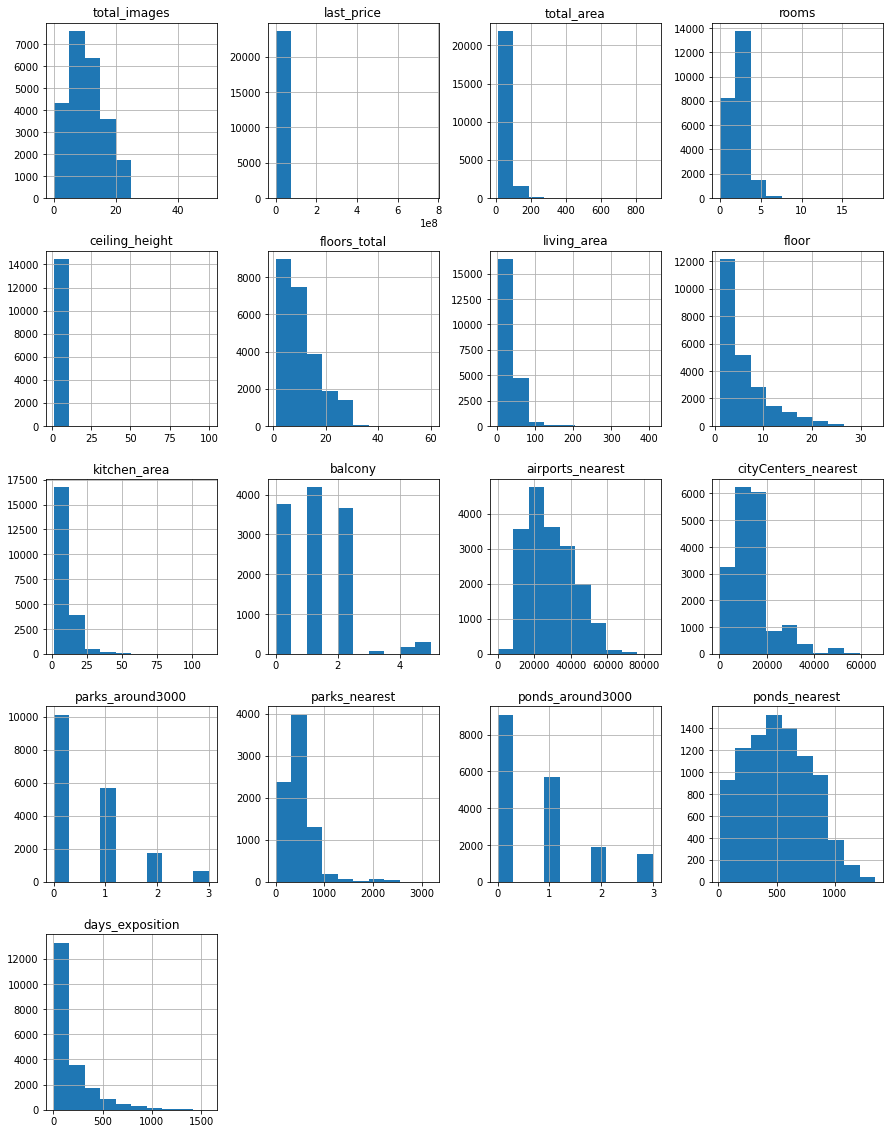

In [139]:
data.hist(figsize=(15, 20));# строим общую гистограмму для всех столбцов таблицы

Сначала найдем и изучим пропущенные значени в столбцах. Затем рассмотрим типы данных в каждом столбце, изучим уникальные значения в столбце с названиями и устраним неявные дубликаты и найдем и устраним редкие и выбивающиеся значения.

In [140]:
data.isna().sum()# находим количество пропущенных значений для каждого столбца

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Пропуски обнаружены в 14 солбцах из 22. Заполним те из них, которые возможно.

In [141]:
data['balcony'] = data['balcony'].fillna(0)# будем считать, что пропуск в столбце с числом балконов означает их отсутствие 

In [142]:
data['is_apartment'] = data['is_apartment'].fillna(False)# is_apartment столбец с булевыми значениями, примем пропуски как False

In [143]:
data['days_exposition'] = data['days_exposition'].fillna(0)# предположим, что пропуск в столбце с количесвтом дней публикации
# означает, что объявление выложили и сняли с публикации в один день, тогда количесвто дней от публикации до снятия 0

In [144]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())# заполним пропуски в столбце
# со значениями высоты потолков медианой

In [145]:
# пропуски в столбце со значениями жилой площади рассчитаем с помощью коэффициента соотношения площадей
ratio_living_area = data['total_area'].mean() / data['living_area'].mean()# рассчитаем коэффициент, как отношение общей средней
# площади к общей жилой площади
data['living_area'] = data['living_area'].fillna(data['total_area'] / ratio_living_area)# заполним пропуски с учетом полученного
# коэффициента

In [146]:
# аналогично заполним пропуски в столбце со значениями площади кухни
ratio_kitchen_area = data['total_area'].mean() / data['kitchen_area'].mean()
data['kitchen_area'] = data['kitchen_area'].fillna(data['total_area'] / ratio_kitchen_area)

Пропуски в столбцах с количеством этажей в здании, названием населённого пункта малочислены, поэтому можем их удалить без особого вреда для исследования.

In [147]:
data = data.dropna(subset=['floors_total', 'locality_name'])# удалим строки с пропущенными значениями

In [148]:
data.isna().sum()# еще раз проверим количесвто пропусков

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000         5500
parks_nearest           15535
ponds_around3000         5500
ponds_nearest           14529
days_exposition             0
dtype: int64

Пропуски остались только в столбцах с картографической информацией, заполнить точной информацией их мы не можем, поэтому оставим как есть.
<br>Пропуски в таблице могли появиться в результате техничсекой ошибки при выгрузке, но вполне возможно, что при заполнении анкеты некоторые параметры просто игнорировались заполняющим и оставались пустыми.

Теперь рассмотрим типы данных в каждом столбце.

In [149]:
data.info()# еще раз изучим общую информацию по датафрейму
data.head(20)# и выведем 20 первых значений

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23565 non-null  int64  
 1   last_price            23565 non-null  float64
 2   total_area            23565 non-null  float64
 3   first_day_exposition  23565 non-null  object 
 4   rooms                 23565 non-null  int64  
 5   ceiling_height        23565 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           23565 non-null  float64
 8   floor                 23565 non-null  int64  
 9   is_apartment          23565 non-null  bool   
 10  studio                23565 non-null  bool   
 11  open_plan             23565 non-null  bool   
 12  kitchen_area          23565 non-null  float64
 13  balcony               23565 non-null  float64
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.000000,8,False,...,25.000000,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,0.0
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,2.65,11.0,18.600000,1,False,...,11.000000,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,2.65,5.0,34.300000,4,False,...,8.300000,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,2.65,14.0,90.785766,9,False,...,27.848168,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.000000,13,False,...,41.000000,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,2.65,12.0,14.400000,5,False,...,9.100000,0.0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,2.65,26.0,10.600000,6,False,...,14.400000,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,2.65,24.0,40.882144,22,False,...,18.900000,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,0.0
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,2.65,27.0,15.430000,26,False,...,8.810000,0.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.600000,7,False,...,6.500000,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


Перед тем как приступать к преобразованию типов в столбцах, переименуем столбец cityCenters_nearest

In [150]:
data = data.rename(columns={'cityCenters_nearest': 'city_centers_nearest'}) 

Теперь можно двигаться дальше. <br>Столбцы с количеством балконов и этажей в доме и количеством дней публикации содержат вещественные числа, это может привести к ошибке при последующих расчетах, поэтому преобразуем их в целые числа. Столбец с датой публикации преобразуем в datetime

In [151]:
data['floors_total'] = data['floors_total'].astype('int')
data['balcony'] = data['balcony'].astype('int')
data['days_exposition'] = data['days_exposition'].astype('int')
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d %H:%M')
data['last_price'] = data['last_price'].astype('int')

In [152]:
data.info()# проверим рузультат преобразования

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  int64         
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        23565 non-null  float64       
 6   floors_total          23565 non-null  int64         
 7   living_area           23565 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  bool          
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          23565 non-null  float64       
 13  balcony         

Типы данных успешно преобразовались, можно приступать к поиску дубликатов в в столбце с названиями

In [153]:
print('Количество явных дубликатов:', data.duplicated().sum())# сначала найдем количество явных дубликатов

Количество явных дубликатов: 0


Явных дубликатов нет, приступим к поиску неявных дубликатов

In [154]:
print('Количество уникальных населенных пунктов:', data['locality_name'].nunique())# найдем количесвто 
# всех уникальных значений в столбце с названиями населенных пунктов

Количество уникальных населенных пунктов: 364


In [155]:
data['locality_name'].sort_values().unique()# изучим уникальные значения

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

Оценить в полном объеме наличие неявных дубликатов сложно, но даже при поверхностоном изучении видны неявные дубликаты в названиях, такие как "поселок" и "посёлок", "городской посёлок" и "посёлок/поселок городского типа", и т.д.
<br> Сначала избавимся от путаницы с написанием "е/ё" в названиях.

In [156]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е', regex=True)# заменим "ё" на "е"
print('Количество уникальных населенных пунктов:', data['locality_name'].nunique())# и проверим,
# как изменилось количесвто дубликатов в столбце

Количество уникальных населенных пунктов: 330


Удалось избавиться от 34 дубликатов в названиях.
<br> Теперь избавимся от дубликатов вида "городской поселок" и "поселок городского типа".

In [157]:
data['locality_name'] = data['locality_name'].str.replace('городской поселок','поселок городского типа', regex = True)# заменим 
# названия, содержащие 'городской поселок' на 'поселок городского типа'
print('Количество уникальных населенных пунктов:', data['locality_name'].nunique())

Количество уникальных населенных пунктов: 323


Удалось избавиться еще от 7 дупликатов. Аналогичным способом приведем остальные наименования в единый вид

In [158]:
data['locality_name'] = data['locality_name'].str.replace('поселок станции','поселок при железнодорожной станции', regex = True)
data['locality_name'] = data['locality_name'].str.replace('садовое товарищество', 
'садоводческое некоммерческое товарищество', regex = True)
print('Количество уникальных населенных пунктов:', data['locality_name'].nunique())

Количество уникальных населенных пунктов: 321


In [159]:
data['locality_name'].sort_values().unique()# проверим как изменились значения в столбце после обработки

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалево',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'деревня Агалатово', 'деревня Аро', 'деревня Батово',
       'деревня Бегуницы', 'деревня Белогорка', 'деревня Большая Вруда',
       'деревня Большая Пустомержа', 'деревня Большие Колпаны',
       'деревня Большое Рейзино', 'деревня Большой Сабск', 'деревня Бор',
       'деревня Борисова Грива', 'деревня Ваганово', 'деревня Вартемяги',
       'деревня Вахнова Кара', 'деревня Выскатка

В общей сложности удалось избавиться от 43 неявных дубликатов. Можно приступать к поиску и устранению аномалий.<br> Изучим столбцы, которые показались сомнительными при первичном ознакомлением с гистограммой, которую мы строили в самом начале работы

In [160]:
data['ceiling_height'].sort_values().unique()# изучим уникальные значения в столбце с высотой помещений

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,
      

В соотвествии со  СНиП 31-01-2003 высота жилых помещений должна составлять не менее 2,5 м. В таком случае необходимо избавиться от тех объектов, для которых высота потолка указана ниже установленной законодательством. Потолки от 3 м обычно считаются высокими, однако в таблице много значений превышающих этот показатель. Отбросим все значения выше 6 м, будем считать что это предельное значение высоты потолков в помещениях, с нестандартными архитектурными решениями (наличие антресолей, многсветных простарнств и др.) Также в таблице присутсвуют значения превышающие 20 м, скорее всего это ошибки, вызванные опечаткой, приведем такие значения к правильному виду.

In [161]:
data.loc[data['ceiling_height'] > 10, 'ceiling_height'] /= 10#  разделим значения больше 10 м на 10
data = data.loc[(data['ceiling_height'] >= 2.5) & (data['ceiling_height'] <= 6)]# оставим только значения из диапазона 2.5 м-6 м
data['ceiling_height'].sort_values().unique()# проверим результат операций

array([2.5 , 2.51, 2.52, 2.53, 2.54, 2.55, 2.56, 2.57, 2.58, 2.59, 2.6 ,
       2.61, 2.62, 2.63, 2.64, 2.65, 2.66, 2.67, 2.68, 2.69, 2.7 , 2.71,
       2.72, 2.73, 2.74, 2.75, 2.76, 2.77, 2.78, 2.79, 2.8 , 2.81, 2.82,
       2.83, 2.84, 2.85, 2.86, 2.87, 2.88, 2.89, 2.9 , 2.91, 2.92, 2.93,
       2.94, 2.95, 2.96, 2.97, 2.98, 2.99, 3.  , 3.01, 3.02, 3.03, 3.04,
       3.05, 3.06, 3.07, 3.08, 3.09, 3.1 , 3.11, 3.12, 3.13, 3.14, 3.15,
       3.16, 3.17, 3.18, 3.2 , 3.21, 3.22, 3.23, 3.24, 3.25, 3.26, 3.27,
       3.28, 3.29, 3.3 , 3.31, 3.32, 3.33, 3.34, 3.35, 3.36, 3.37, 3.38,
       3.39, 3.4 , 3.42, 3.43, 3.44, 3.45, 3.46, 3.47, 3.48, 3.49, 3.5 ,
       3.51, 3.52, 3.53, 3.54, 3.55, 3.56, 3.57, 3.58, 3.59, 3.6 , 3.62,
       3.63, 3.65, 3.66, 3.67, 3.68, 3.69, 3.7 , 3.75, 3.76, 3.78, 3.8 ,
       3.82, 3.83, 3.84, 3.85, 3.86, 3.87, 3.88, 3.9 , 3.93, 3.95, 3.98,
       4.  , 4.06, 4.1 , 4.14, 4.15, 4.19, 4.2 , 4.25, 4.3 , 4.37, 4.4 ,
       4.45, 4.5 , 4.65, 4.7 , 4.8 , 4.9 , 5.  , 5.

Теперь рассмотрим столбец, содержащий информацию о количестве комнат

In [162]:
data['rooms'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 19])

В столбце rooms есть нулевые значения, рассмотрим детальнее этот момент.

In [163]:
# найдем количесвто помещений без комнат
print('Количество объектов, количество комнат в которых = 0:', len(data[data['rooms'] == 0]))

Количество объектов, количество комнат в которых = 0: 194


В таблице 194 объекта с количеством комнат 0. В помещении должна быть минимум 1 комната, поэтому удалим все строки, где комнат 0

In [164]:
data = data[data['rooms'] != 0]# оставим объекты, где количсество комнат больше 0
data['rooms'].sort_values().unique()# проверим результат удаления

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 19])

Теперь проверим записи в таблице, в которых комнат больше 10

In [165]:
data.loc[data['rooms'] > 10]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
648,3,17500000,183.7,2018-07-01,11,3.40,7,138.8,7,False,...,13.3,0,Санкт-Петербург,23606.0,3148.0,0.0,NaN,0.0,NaN,0
866,5,25000000,363.0,2017-12-23,14,3.16,5,222.0,4,False,...,16.6,0,Санкт-Петербург,38076.0,7950.0,0.0,NaN,2.0,435.0,418
5358,20,65000000,590.0,2019-02-14,15,3.50,6,409.0,3,False,...,100.0,0,Санкт-Петербург,24447.0,4666.0,1.0,767.0,0.0,NaN,14
9688,8,33000000,194.1,2017-02-07,11,3.43,5,129.0,2,False,...,11.9,0,Санкт-Петербург,21469.0,1015.0,1.0,686.0,2.0,66.0,813
14498,6,32250000,374.6,2018-06-09,19,2.65,5,264.5,2,False,...,27.6,0,Санкт-Петербург,19497.0,3574.0,0.0,NaN,2.0,548.0,114
18848,6,28500000,270.0,2015-03-02,16,3.00,4,180.0,4,False,...,13.0,1,Санкт-Петербург,23575.0,4142.0,1.0,516.0,0.0,NaN,1365
19540,8,420000000,900.0,2017-12-06,12,2.80,25,409.7,25,False,...,112.0,0,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106
20829,6,28659000,245.4,2016-03-31,14,2.65,4,168.3,2,False,...,25.9,0,Санкт-Петербург,21104.0,2054.0,3.0,541.0,2.0,118.0,95


В таблице содержиться 8 объектов, с количеством комнат больше 10. Общая площадь этих объектов больше 180 кв.м. Логично, что в объектах с большой площадью много комнат, поэтому оставим эти записи без изменений. 

Изучим информацию о площади объектов

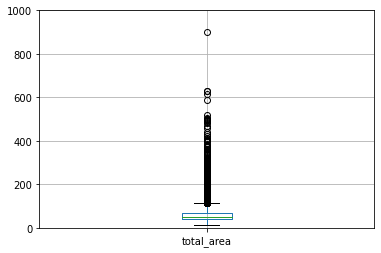

In [166]:
# посторим диаграмму размаха, чтобы наглядно увидеть распределение площадей объектов
data.boxplot(column=['total_area'])
plt.ylim(0, 1000);

На диаграмме видно, что самая большая чать объявлений - объекты площадью менее 100 кв.м. Наблюдаем выбросы, квартиры с площадями больше 100 кв.м.<br> Отбросим объявления с площадью квартир больше 200 кв.м.: таких объявлений мало, но значения в них сильно выбиваются из общего ряда, это может негативно отразиться на последующих исследованиях

In [167]:
data = data[data['total_area'] <= 200]# исключим из таблицы строки с объектами больше 200 кв.м.
data['total_area'].sort_values().unique()# проеврим результат исключения

array([ 12. ,  13. ,  13.2, ..., 198.9, 199.2, 200. ])

Самая большая площадь в таблице 200 кв.м. В таблице нет выбивающихся значений, можно двигаться дальше

Последним рассмотрим столбец с количеством дней публикации

In [168]:
data['days_exposition'].sort_values().unique()

array([   0,    1,    2, ..., 1553, 1572, 1580])

Удалим нулевые значения из таблицы

In [169]:
data = data[data['days_exposition'] != 0]# исключим из таблицы строки
data['days_exposition'].sort_values().unique()# проеврим результат исключения

array([   1,    2,    3, ..., 1553, 1572, 1580])

Строки исключены, можно двигаться дальше

### Подготовка данных к исследовательскому анализу 

В таблицу нужно добавить информацию о цене одного квадратного метра.

In [170]:
data['price_one_sq_m'] = data['last_price'] / data['total_area']# цена за один квадратный метр рассчитывается как отношение
# стоимости объекта к его общей площади
data['price_one_sq_m'] = data['price_one_sq_m'].round(1)# округлим до десятых
data.head(10)# проверим результат добавления столбца

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_one_sq_m
1,7,3350000,40.40,2018-12-04,1,2.65,11,18.600000,1,False,...,2,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81,82920.8
2,10,5196000,56.00,2015-08-20,2,2.65,5,34.300000,4,False,...,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558,92785.7
3,0,64900000,159.00,2015-07-24,3,2.65,14,90.785766,9,False,...,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424,408176.1
4,2,10000000,100.00,2018-06-19,2,3.03,14,32.000000,13,False,...,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121,100000.0
5,10,2890000,30.40,2018-09-10,1,2.65,12,14.400000,5,False,...,0,поселок городского типа Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55,95065.8
6,6,3700000,37.30,2017-11-02,1,2.65,26,10.600000,6,False,...,1,поселок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155,99195.7
8,20,2900000,33.16,2018-05-23,1,2.65,27,15.430000,26,False,...,0,поселок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189,87454.8
9,18,5400000,61.00,2017-02-26,3,2.50,9,43.600000,7,False,...,2,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289,88524.6
10,5,5050000,39.60,2017-11-16,1,2.67,12,20.300000,3,False,...,0,Санкт-Петербург,38357.0,13878.0,1.0,310.0,2.0,553.0,137,127525.3
11,9,3300000,44.00,2018-08-27,2,2.65,5,31.000000,4,False,...,1,Ломоносов,48252.0,51677.0,0.0,NaN,0.0,NaN,7,75000.0


Столбец с ценой одного квадратного метра успешно добавлен. Теперь добавим столбец с днем недели публикации

In [171]:
data['weekday'] = data['first_day_exposition'].dt.weekday
data.head(10)# проверим результат добавления столбца

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_one_sq_m,weekday
1,7,3350000,40.40,2018-12-04,1,2.65,11,18.600000,1,False,...,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81,82920.8,1
2,10,5196000,56.00,2015-08-20,2,2.65,5,34.300000,4,False,...,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558,92785.7,3
3,0,64900000,159.00,2015-07-24,3,2.65,14,90.785766,9,False,...,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424,408176.1,4
4,2,10000000,100.00,2018-06-19,2,3.03,14,32.000000,13,False,...,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121,100000.0,1
5,10,2890000,30.40,2018-09-10,1,2.65,12,14.400000,5,False,...,поселок городского типа Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55,95065.8,0
6,6,3700000,37.30,2017-11-02,1,2.65,26,10.600000,6,False,...,поселок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155,99195.7,3
8,20,2900000,33.16,2018-05-23,1,2.65,27,15.430000,26,False,...,поселок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189,87454.8,2
9,18,5400000,61.00,2017-02-26,3,2.50,9,43.600000,7,False,...,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289,88524.6,6
10,5,5050000,39.60,2017-11-16,1,2.67,12,20.300000,3,False,...,Санкт-Петербург,38357.0,13878.0,1.0,310.0,2.0,553.0,137,127525.3,3
11,9,3300000,44.00,2018-08-27,2,2.65,5,31.000000,4,False,...,Ломоносов,48252.0,51677.0,0.0,NaN,0.0,NaN,7,75000.0,0


Столбец успешо добавлен. Теперь добавим столбцы с месяцем и годом публикации

In [172]:
data['month'] = data['first_day_exposition'].dt.month# добавляем месяц
data['year'] = data['first_day_exposition'].dt.year# добавляем год
data.head(10)# проверим результат добавления столбцов

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_one_sq_m,weekday,month,year
1,7,3350000,40.40,2018-12-04,1,2.65,11,18.600000,1,False,...,18603.0,0.0,NaN,0.0,NaN,81,82920.8,1,12,2018
2,10,5196000,56.00,2015-08-20,2,2.65,5,34.300000,4,False,...,13933.0,1.0,90.0,2.0,574.0,558,92785.7,3,8,2015
3,0,64900000,159.00,2015-07-24,3,2.65,14,90.785766,9,False,...,6800.0,2.0,84.0,3.0,234.0,424,408176.1,4,7,2015
4,2,10000000,100.00,2018-06-19,2,3.03,14,32.000000,13,False,...,8098.0,2.0,112.0,1.0,48.0,121,100000.0,1,6,2018
5,10,2890000,30.40,2018-09-10,1,2.65,12,14.400000,5,False,...,NaN,NaN,NaN,NaN,NaN,55,95065.8,0,9,2018
6,6,3700000,37.30,2017-11-02,1,2.65,26,10.600000,6,False,...,19143.0,0.0,NaN,0.0,NaN,155,99195.7,3,11,2017
8,20,2900000,33.16,2018-05-23,1,2.65,27,15.430000,26,False,...,NaN,NaN,NaN,NaN,NaN,189,87454.8,2,5,2018
9,18,5400000,61.00,2017-02-26,3,2.50,9,43.600000,7,False,...,15008.0,0.0,NaN,0.0,NaN,289,88524.6,6,2,2017
10,5,5050000,39.60,2017-11-16,1,2.67,12,20.300000,3,False,...,13878.0,1.0,310.0,2.0,553.0,137,127525.3,3,11,2017
11,9,3300000,44.00,2018-08-27,2,2.65,5,31.000000,4,False,...,51677.0,0.0,NaN,0.0,NaN,7,75000.0,0,8,2018


Столбцы добавлены. Теперь нужно создать столбец, в котором будет указан тип этажа квартиры (значения — «‎первый», «последний», «другой»)

In [173]:
# создадим функцию, в которой присвоим этажу нужное значение
def floor_type(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
data['floor_type'] = data.apply(floor_type, axis=1)# добавим в таблицу столбец с типом этажа
data.head(10)# проверим результат 

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_one_sq_m,weekday,month,year,floor_type
1,7,3350000,40.40,2018-12-04,1,2.65,11,18.600000,1,False,...,0.0,NaN,0.0,NaN,81,82920.8,1,12,2018,первый
2,10,5196000,56.00,2015-08-20,2,2.65,5,34.300000,4,False,...,1.0,90.0,2.0,574.0,558,92785.7,3,8,2015,другой
3,0,64900000,159.00,2015-07-24,3,2.65,14,90.785766,9,False,...,2.0,84.0,3.0,234.0,424,408176.1,4,7,2015,другой
4,2,10000000,100.00,2018-06-19,2,3.03,14,32.000000,13,False,...,2.0,112.0,1.0,48.0,121,100000.0,1,6,2018,другой
5,10,2890000,30.40,2018-09-10,1,2.65,12,14.400000,5,False,...,NaN,NaN,NaN,NaN,55,95065.8,0,9,2018,другой
6,6,3700000,37.30,2017-11-02,1,2.65,26,10.600000,6,False,...,0.0,NaN,0.0,NaN,155,99195.7,3,11,2017,другой
8,20,2900000,33.16,2018-05-23,1,2.65,27,15.430000,26,False,...,NaN,NaN,NaN,NaN,189,87454.8,2,5,2018,другой
9,18,5400000,61.00,2017-02-26,3,2.50,9,43.600000,7,False,...,0.0,NaN,0.0,NaN,289,88524.6,6,2,2017,другой
10,5,5050000,39.60,2017-11-16,1,2.67,12,20.300000,3,False,...,1.0,310.0,2.0,553.0,137,127525.3,3,11,2017,другой
11,9,3300000,44.00,2018-08-27,2,2.65,5,31.000000,4,False,...,0.0,NaN,0.0,NaN,7,75000.0,0,8,2018,другой


Функция работает и столбец успешно добавлен. Осталось добавить последний столбец с расстоянием до центра города в километрах

In [174]:
data['city_centers_nearest_km'] = data['city_centers_nearest'] / 1000# переводим м в км и добавляем столбец
data['city_centers_nearest_km'] = data['city_centers_nearest_km'].round()# округляем занчения в столбце до целых
data.head(10)# проверим результат 

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_one_sq_m,weekday,month,year,floor_type,city_centers_nearest_km
1,7,3350000,40.40,2018-12-04,1,2.65,11,18.600000,1,False,...,NaN,0.0,NaN,81,82920.8,1,12,2018,первый,19.0
2,10,5196000,56.00,2015-08-20,2,2.65,5,34.300000,4,False,...,90.0,2.0,574.0,558,92785.7,3,8,2015,другой,14.0
3,0,64900000,159.00,2015-07-24,3,2.65,14,90.785766,9,False,...,84.0,3.0,234.0,424,408176.1,4,7,2015,другой,7.0
4,2,10000000,100.00,2018-06-19,2,3.03,14,32.000000,13,False,...,112.0,1.0,48.0,121,100000.0,1,6,2018,другой,8.0
5,10,2890000,30.40,2018-09-10,1,2.65,12,14.400000,5,False,...,NaN,NaN,NaN,55,95065.8,0,9,2018,другой,NaN
6,6,3700000,37.30,2017-11-02,1,2.65,26,10.600000,6,False,...,NaN,0.0,NaN,155,99195.7,3,11,2017,другой,19.0
8,20,2900000,33.16,2018-05-23,1,2.65,27,15.430000,26,False,...,NaN,NaN,NaN,189,87454.8,2,5,2018,другой,NaN
9,18,5400000,61.00,2017-02-26,3,2.50,9,43.600000,7,False,...,NaN,0.0,NaN,289,88524.6,6,2,2017,другой,15.0
10,5,5050000,39.60,2017-11-16,1,2.67,12,20.300000,3,False,...,310.0,2.0,553.0,137,127525.3,3,11,2017,другой,14.0
11,9,3300000,44.00,2018-08-27,2,2.65,5,31.000000,4,False,...,NaN,0.0,NaN,7,75000.0,0,8,2018,другой,52.0


Все получилось, но в столбце есть пропуски, из-за того что картографические данные мы не обрабатывали и оставили как есть

### Исследовательский анализ данных

Проанализируем общую площадь объектов

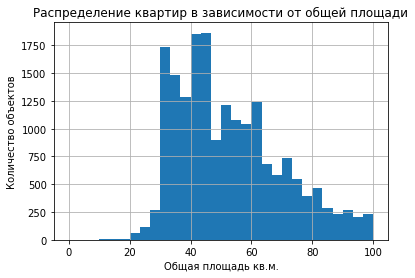

In [175]:
data['total_area'].hist(bins=30, range=(0, 100))# строим гистограмму и задаем ей необходимые параметры
plt.xlabel('Общая площадь кв.м.')
plt.ylabel('Количество объектов')
plt.title('Распределение квартир в зависимости от общей площади');

На графике заметны несколько пиковых значений: это квартиры площадью около 30 кв.м., квартиры площадью 40-50 кв.м. и площадью 60 кв.м. Эти пики, скорее всего, вызваны изменением среднестатистической площади, харкатерной для одно-, двух- и трехкомнатных квартир соотвественно
Сделанный на этапе предобработки вывод подтвердился: наибольшее число объявлений о квартирах с площадью до 100 кв.м. Квартир большей площади значительно меньше. Самое большое количество объявлений об объектах площадью 30-65 кв.м.

Исследуем жилую площадь 

Text(0.5, 1.0, 'Распределение квартир в зависимости от жилой площади')

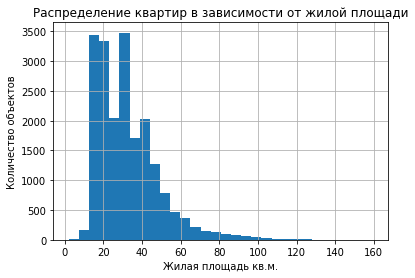

In [176]:
data['living_area'].hist(bins=30)# строим гистограмму и задаем ей необходимые параметры
plt.xlabel('Жилая площадь кв.м.')
plt.ylabel('Количество объектов')
plt.title('Распределение квартир в зависимости от жилой площади')

Наибольшее количество объектов с жилой площадью до 50 кв.м. На графике четко выражены 3 пика, вероятно так отображается разница в соотношении жилых площадей в одно-, двух- и трехкомнатных картирах

Исследуем площадь кухни

Text(0.5, 1.0, 'Распределение квартир в зависимости от площади кухни')

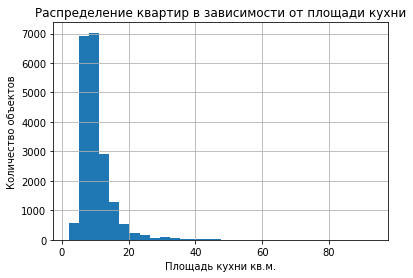

In [177]:
data['kitchen_area'].hist(bins=30)# строим гистограмму и задаем ей необходимые параметры
plt.xlabel('Площадь кухни кв.м.')
plt.ylabel('Количество объектов')
plt.title('Распределение квартир в зависимости от площади кухни')

Кухни площадью более 20 кв.м. практически не встречаются, наиболее распрастраненное значение площади кухни 5-15 кв.м.

Исследуем распределение объектов в зависимости от цены

Text(0.5, 1.0, 'Распределение квартир в зависимости от цены')

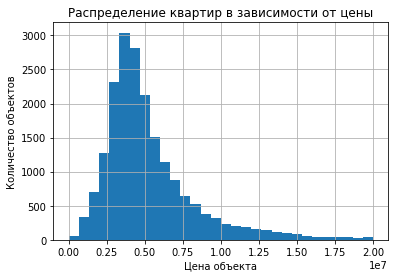

In [178]:
data['last_price'].hist(bins=30, range=(0,20000000))
plt.xlabel('Цена объекта')
plt.ylabel('Количество объектов')
plt.title('Распределение квартир в зависимости от цены')

Наибольшее количество объектов находятся в ценовом диапазоне до 5-6 млн. Объекты дороже встречаются, но чем выше цена, тем меньше таких объектов

Рассмотрим распределение объектов в зависимости от количества комнат

Text(0.5, 1.0, 'Распределение квартир в зависимости от количества комнат')

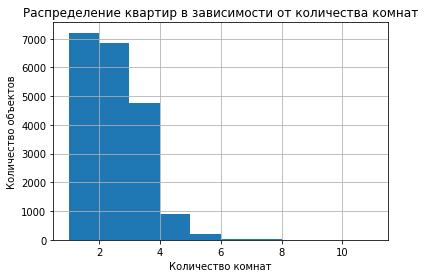

In [179]:
data['rooms'].hist(bins=10)
plt.xlabel('Количество комнат')
plt.ylabel('Количество объектов')
plt.title('Распределение квартир в зависимости от количества комнат')

Самые распрастраненные варианты это одно-, двух- и трехкомнатые объекты. Объекты с 4 комнатами тоже встречаются, но реже. Встречаются единичные варианты объектов в которых больше 6 комнат

Рассмотрим распределение объектов в зависимости от высоты потолков

Text(0.5, 1.0, 'Распределение квартир в зависимости от высоты потолка')

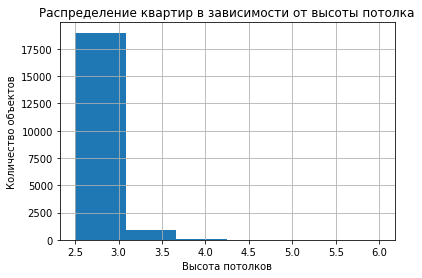

In [180]:
data['ceiling_height'].hist(bins=6)
plt.xlabel('Высота потолков')
plt.ylabel('Количество объектов')
plt.title('Распределение квартир в зависимости от высоты потолка')

В подавляющем большинстве случаев высота потолков находистя в диапазоне от 2,5 м. до 3,1 м. 

Рассмотрим распределение объектов в зависимости от того, на каком этаже они расположены

Text(0.5, 1.0, 'Распределение квартир в зависимости от положения на этаже')

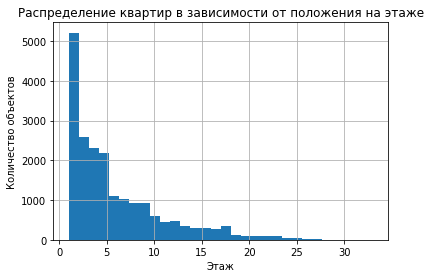

In [181]:
data['floor'].hist(bins=30)
plt.xlabel('Этаж')
plt.ylabel('Количество объектов')
plt.title('Распределение квартир в зависимости от положения на этаже')

Наибольшее количество объектов расположено не выше 5 этажа. Это связанно стем, что в агломерациях Санкт-Петербурга преобладает мало- и среднеэтажная застройка. Резкие просадки по количеству объектов, расположенных выше 2, 5 и 9 этажей можно объяснить тем, что наиболее распростарнными типами застройки являются двухэтажные, пятиэтажные и девятиэтажные дома

Рассмотрим типы этажей, на которых расположены объекты

Text(0.5, 1.0, 'Типы этажей')

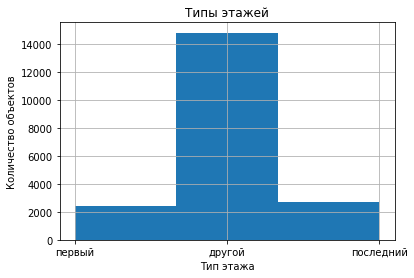

In [182]:
data['floor_type'].hist(bins=3)
plt.xlabel('Тип этажа')
plt.ylabel('Количество объектов')
plt.title('Типы этажей')

Количество объектов на первых и последних этажах примерно равно, но это количество в несколько раз меньше, чем объектов рассположенных на других этажах

Теперь рассмторим общее количесвто этажей в доме

Text(0.5, 1.0, 'Количество этажей в доме')

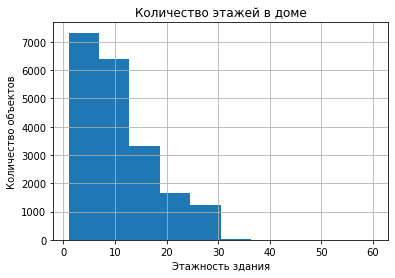

In [183]:
data['floors_total'].hist(bins=10)
plt.xlabel('Этажность здания')
plt.ylabel('Количество объектов')
plt.title('Количество этажей в доме')

Наибольшее количество зданий не выше 10 этажей. Выше мы уже говорили о причинах такого расспределени: в агломерациях Санкт-Петербурга преобладает мало- и среднеэтажная застройка. 

Изучим распределение объектов в зависимости от расстояния до центра города

Text(0.5, 1.0, 'Расстояние до центра города')

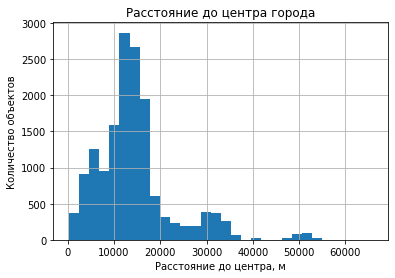

In [184]:
data['city_centers_nearest'].hist(bins=30)
plt.xlabel('Расстояние до центра, м')
plt.ylabel('Количество объектов')
plt.title('Расстояние до центра города')

Наибольшее количесвто квартир расположено на удалении 10000-15000 м от центра. После 15000 м происходит резкий спад количества предложений

Изучим распределение объектов в зависимости от расстояния до ближайшего аэропорта

Text(0.5, 1.0, 'Расстояние до аэропорта')

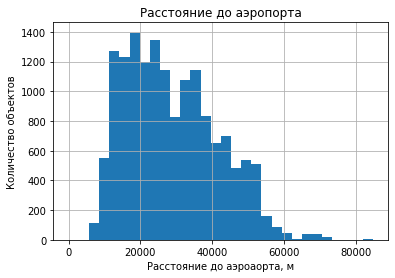

In [185]:
data['airports_nearest'].hist(bins=30)
plt.xlabel('Расстояние до аэроаорта, м')
plt.ylabel('Количество объектов')
plt.title('Расстояние до аэропорта')

Подавляющее большинство объектов расположено в радиусе 10000-40000 м от аэропорта

Изучим распределение объектов в зависимости от расстояния до ближайшего парка

Text(0.5, 1.0, 'Расстояние до парка')

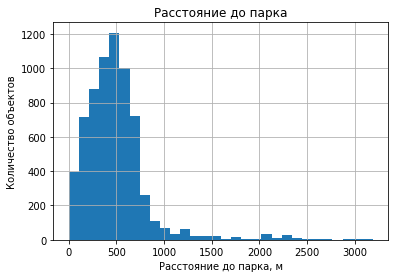

In [186]:
data['parks_nearest'].hist(bins=30)
plt.xlabel('Расстояние до парка, м')
plt.ylabel('Количество объектов')
plt.title('Расстояние до парка')

Почти все объекты расположены в радиусе меньше 1 км от ближайшего парка

Изучим распределение объектов в зависимости от дня и месяца подачи объявления

Text(0.5, 1.0, 'День публикации объявления')

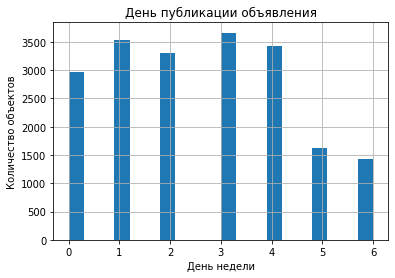

In [187]:
data['weekday'].hist(bins=20)
plt.xlabel('День недели')
plt.ylabel('Количество объектов')
plt.title('День публикации объявления')

Text(0.5, 1.0, 'Месяц публикации объявления')

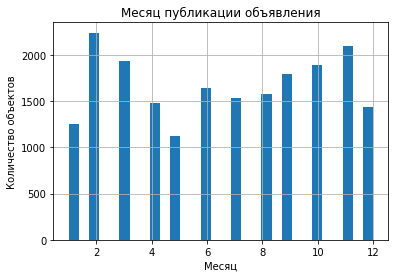

In [188]:
data['month'].hist(bins=30)
plt.xlabel('Месяц')
plt.ylabel('Количество объектов')
plt.title('Месяц публикации объявления')

Наибольшее количество объявлений опубликованы в будние дни, количество публикаций во вторник и четверг немного выше, чем в другой будний день. <br> Больше всего публикаций делается в начале года: с февраля по апрель. Меньше всего публикаций сделано в мае.

Теперь изучим скорость, с которой продавались квартиры

In [189]:
data.query('days_exposition != 9999')['days_exposition'].describe()# изучим значение срока продаж

count    19969.000000
mean       180.284391
std        218.872012
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

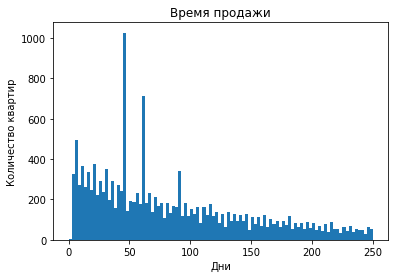

In [190]:
plt.hist(data.query('days_exposition != 9999')['days_exposition'], bins=100, range=(0,250))# и построим гистограмму
plt.title('Время продажи')
plt.xlabel('Дни')
plt.ylabel('Количество квартир')
plt.show()

Среднее время продажи квартиры - 181 день, медианное время - 95 дня. В среднем квартиры продаются за 100 дней, но есть большое число квартир, которые продаются в первые дни публикации и которые остаются в продаже многие месяцы. На графике особенно сильно выделяются 2 пиковых значения: 45 и 60 дней. Эти аномалии очень похожи на техническую особенность самой платформы: вероятнее, в эти дни платформа автоматически убирает объявления, если пользователь его не продлил.

Изучим влияние различных факторов на полную стоимсоть объекта

Рассмторим влияние общей площади на стоимсоть объекта

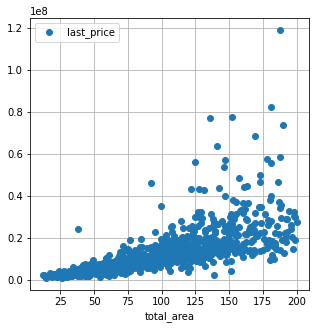

,last_price,total_area
last_price,1.000000,0.926739
total_area,0.926739,1.000000


In [191]:
(
    data.pivot_table(index='total_area', values='last_price')
    .plot(grid=True, style='o', figsize=(5, 5))
)
plt.show()
data.pivot_table(index='floor', values=['total_area', 'last_price']).corr()# найдем корреляцию цены и общей площади

Корреляция цены и площади очень высокая: чем больше площадь объекта, тем выше его стоимость

Рассмторим влияние жилой площади на стоимость объекта

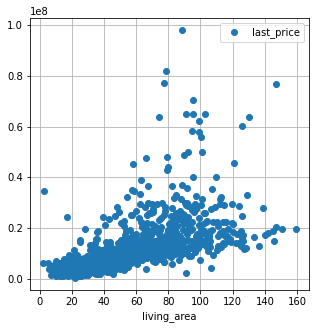

,last_price,living_area
last_price,1.000000,0.819734
living_area,0.819734,1.000000


In [192]:
(
    data.pivot_table(index='living_area', values='last_price')
    .plot(grid=True, style='o', figsize=(5, 5))
)
plt.show()
data.pivot_table(index='floor', values=['living_area', 'last_price']).corr()# найдем корреляцию цены и жилой площади

Корреляция цены и жилой площади тоже высокая, но чуть ниже чем корреляция цены и общей площади

Рассмторим влияние площади кухни на стоимость объекта

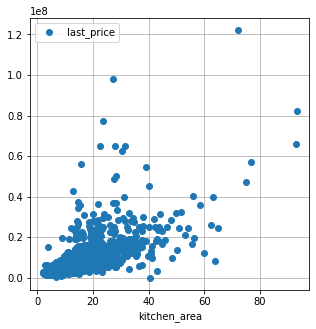

,kitchen_area,last_price
kitchen_area,1.000000,0.494114
last_price,0.494114,1.000000


In [193]:
(
    data.pivot_table(index='kitchen_area', values='last_price')
    .plot(grid=True, style='o', figsize=(5, 5))
)
plt.show()
data.pivot_table(index='floor', values=['kitchen_area', 'last_price']).corr()# найдем корреляцию цены и площади кухни

В данном случае наблюдается слабая корреляция, увеличение площади кухни влияет на увеличение цены, но скорее всего большую роль здесь играет увеличение общей площади объекта

Рассмторим влияние количества комнат на стоимость объекта

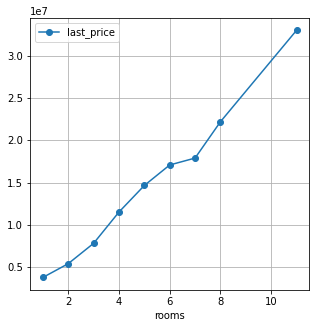

,last_price,rooms
last_price,1.000000,0.696238
rooms,0.696238,1.000000


In [194]:
(
    data.pivot_table(index='rooms', values='last_price')
    .plot(grid=True, style='o-', figsize=(5, 5))
)
plt.show()
data.pivot_table(index='floor', values=['rooms', 'last_price']).corr()# найдем корреляцию цены и количества комнат

Корреляция между ценой и количеством комнат средняя. Логично предположить, что с увеличением комнат увеличивается и общая площадь, а как мы выяснили ранее - самая сильная корреляция между ценой и общей площадью объекта

Рассмторим влияние типа этажа, на котором рассположен объект на его стоимость 

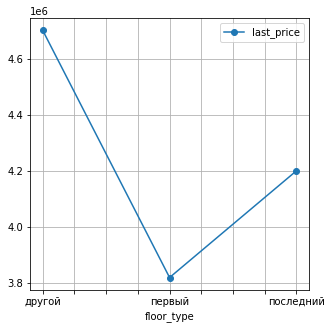

In [195]:
(
    data.pivot_table(index='floor_type', values='last_price', aggfunc='median')
    .plot(grid=True, style='o-', figsize=(5, 5))
)
plt.show()

На первом этаже квартиры значительно дешевле, чем на других этажах. На последнем этаже квартиры немного дороже, но все еще дешевле, чем остальные квартиры. Самые дорогие квартиры расположены между первым и последним этажами

Рассмторим влияние даты размещения объявления на стоимость объекта

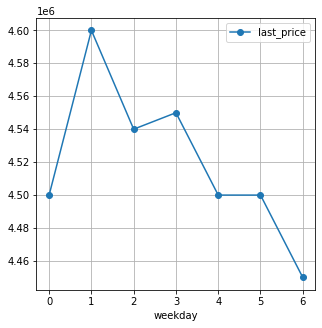

,last_price,weekday
last_price,1.000000,0.136996
weekday,0.136996,1.000000


In [196]:
(
    data.pivot_table(index='weekday', values='last_price', aggfunc='median')
    .plot(grid=True, style='o-', figsize=(5, 5))
)
plt.show()
data.pivot_table(index='floor', values=['weekday', 'last_price']).corr()# найдем корреляцию цены и дня публикации объявления

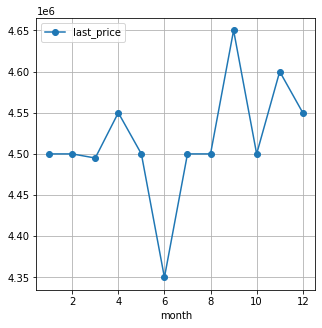

,last_price,month
last_price,1.000000,-0.088309
month,-0.088309,1.000000


In [197]:
(
    data.pivot_table(index='month', values='last_price', aggfunc='median')
    .plot(grid=True, style='o-', figsize=(5, 5))
)
plt.show()
data.pivot_table(index='floor', values=['month', 'last_price']).corr()# найдем корреляцию цены и месяца публикации объявления

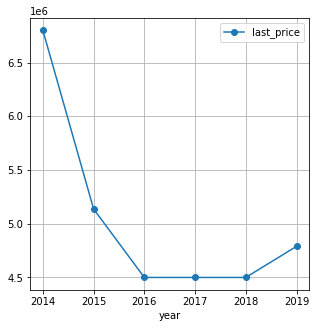

,last_price,year
last_price,1.000000,-0.144618
year,-0.144618,1.000000


In [198]:
(
    data.pivot_table(index='year', values='last_price', aggfunc='median')
    .plot(grid=True, style='o-', figsize=(5, 5))
)
plt.show()
data.pivot_table(index='floor', values=['year', 'last_price']).corr()# найдем корреляцию цены и года публикации объявления

Между датой публикации объявления и ценой очень слабая корреляция, в случае с месяцем и годом корреляция слабая и отрицательная. На основании этого можно сделать вывод, что дата публикации никак не влияет на цену объекта

Сравним среднюю стоимость квадратного метра в 10 городах, с самым большим числом объявлений

In [199]:
city_high_rating = data['locality_name'].value_counts().head(10)# найдем 10 городов с самым большим количесвтом объявлений
city_mean_price = data.query('locality_name in (@city_high_rating.index)').pivot_table(values='price_one_sq_m', 
    index='locality_name')# по срезу данных, в котором содержаться названия этих городов, строим сводную таблицу
city_mean_price = city_mean_price.astype(int)# приведем к целочисленному значению
city_mean_price.sort_values('price_one_sq_m', ascending=False)

,price_one_sq_m
locality_name,
Санкт-Петербург,111013
Пушкин,102092
деревня Кудрово,92297
поселок Парголово,89820
поселок Мурино,85088
поселок Шушары,77570
Колпино,74782
Всеволожск,68530
Гатчина,67928


Ожидаемо, самые дорогие квдаратные метры площади в Санкт-Петербурге. Высокая стоимость квадратного метра также наблюдается в Пушкине, что можно обосновать привлекательностью застройки, архитектуры и благоустройства терртории. Наименьшая стоимость в населенных пунктах, рассположенных в отдалении от Санкт-Петербурга (Всеволожск, Гатчина, Выборг)

На финальном этапе исследования вычислим среднюю цену каждого километра при отдалении от центра города

In [200]:
data.query('locality_name == "Санкт-Петербург"').pivot_table(index='city_centers_nearest_km', values='last_price').round(1)

,last_price
city_centers_nearest_km,
0.0,19010742.8
1.0,14717523.2
2.0,13146525.8
3.0,9717873.2
4.0,10457734.7
5.0,11149486.0
6.0,11836610.3
7.0,12680772.4
8.0,8463446.3


Центральная зона определена в радиусе 7 км - после этого значения стоимость резко падает: средняя стоимость квратиры в 7 км от центра - 12680772.4, в то время как средняя стоимость квратиры в 8 км от центра - 8463446.3)

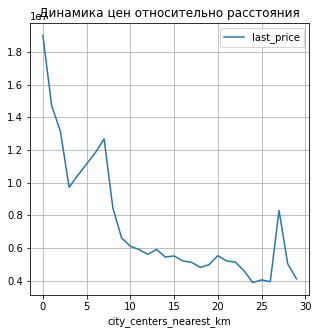

In [201]:
# построим линейный график для наглядности
(
    data.query('locality_name == "Санкт-Петербург"').pivot_table(index='city_centers_nearest_km', values='last_price').round(1)
    .plot(grid=True, style='-', figsize=(5, 5), title = 'Динамика цен относительно расстояния')
)
plt.show()

На графике подтвердились сделанные ранее выводы, помимо этого теперь наглядно видно, что внутри центральной зоны города стоимость объектов тоже неодинакова - наблюдается снижение цены для объектов расположенных в 3 км от центра</div>

### Общий вывод

На первых этапах работы над проектом была осуществлена предобработка данных: найдены и удалены пропуски дубликаты и аномальные значения в данных. На последних этапах проводилась исследовательская работа на основании обработанных данных.
<br>По результатам исследования можно сделать следующие выводы:
- самое сильное влияние на стоимость квартир оказывает их общая площадь: чем больше площадь, тем дроже объект. При этом, количество комнат не играет здесь большой роли;
- квартиры, расположенные на первом этаже, значительно дешевле, чем квартиры на других этажах. Квартиры на последенем этаже также дешевле, чем любые другие, расположенные выше 1 этажа;
- в среднем квартиры продаются за 100 дней, но также есть значимый процент объектов, которые продавались в первые дни публикации;
- на стоимость квартир также влияет их удаленность от центра города: в пределах центра (в радиусе 7 км) квартиры дороже, чем в другом месте города;
- среди населенных пунктов, с самым большим количеством объявлений, самая высокая цена за один квадратный метр в Санкт-Петербурге, самая низкая - в Выборге.
